In [2]:
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import statsmodels.formula.api as smf

In [3]:
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

In [4]:
# load data
d = pd.read_csv('Data/WaffleDivorce.csv', sep=';')
# standardize predictor
d['MedianAgeMarriage_s'] = (d.MedianAgeMarriage - d.MedianAgeMarriage.mean()) / d.MedianAgeMarriage.std()

In [5]:
d.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860,MedianAgeMarriage_s
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45,-0.606290
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00,-0.686699
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00,-0.204241
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26,-1.410387
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00,0.599857


In [6]:
with pm.Model() as model_5_1:
    a = pm.Normal('a', mu=0, sd=.2)
    bA = pm.Normal('bA', mu=0, sd=.5)
    sigma = pm.Exponential('sigma', lam=1)
    # good (default) alternatives for sigma (in this and other models) are
    # sigma = pm.HalfNormal('sigma', 5)
    # sigma = pm.HalfCauchy('sigma', 5)
    # some people recomed avoiding "hard" boundaries unless they have a theoretical/data-based justification, like a correlation that is restricted to be [-1, 1].
    mu = pm.Deterministic('mu', a + bA * d.MedianAgeMarriage_s)
    Divorce = pm.Normal('Divorce', mu=mu, sd=sigma, observed=d.Divorce)
    trace_5_1 = pm.sample(1000, tune=1000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bA, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1535.39draws/s]


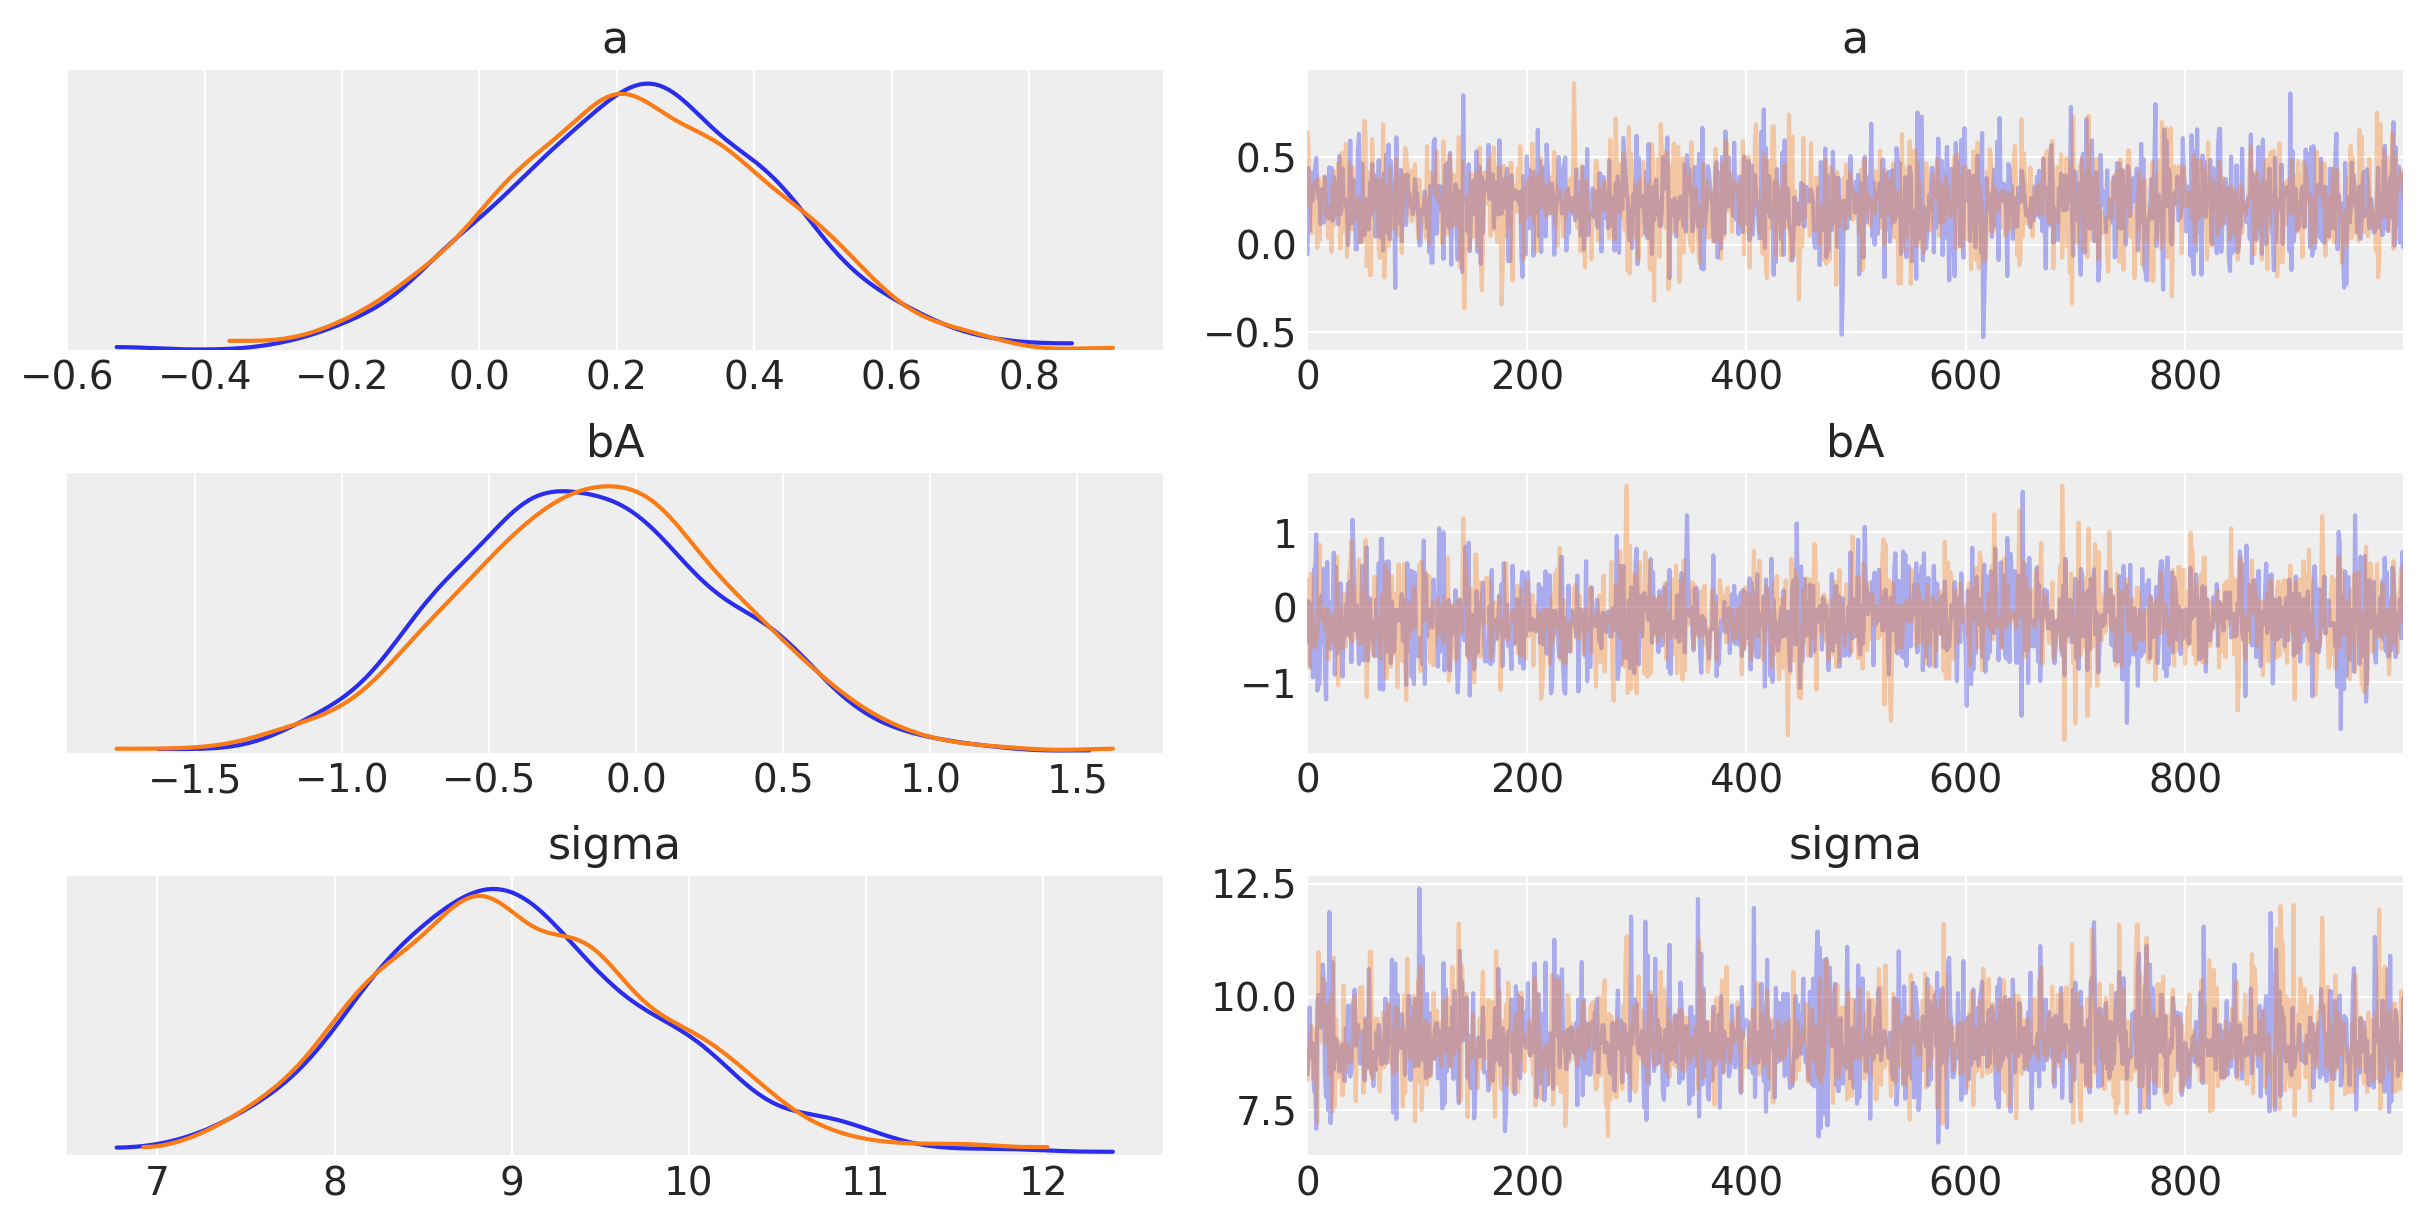

In [7]:
varnames = ['~mu']
az.plot_trace(trace_5_1, varnames);

In [8]:
d['Marriage_s'] = (d.Marriage - d.Marriage.mean()) / d.Marriage.std()

In [9]:
with pm.Model() as multreg:
    a=pm.Normal('a',mu=0, sd=0.2)
    beta=pm.Normal('Ba',mu=0, sd=0.5,shape=2)
    
    sigma=pm.Exponential('sigma', lam=1)
    mu=pm.Deterministic('mu', a + beta[0] * d.Marriage_s + beta[1] * d.MedianAgeMarriage_s)
    Divorce=pm.Normal('Divorce',mu=mu, sd=sigma, observed=d.Divorce)
    trace_multreg = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, Ba, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1131.80draws/s]


In [10]:
az.summary(trace_multreg, varnames, credible_interval=.89).round(3)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.236,0.200,-0.090,0.545,0.004,0.003,3112.0,2152.0,3108.0,1481.0,1.0
Ba[0],0.073,0.467,-0.677,0.816,0.008,0.010,3275.0,1115.0,3256.0,1730.0,1.0
Ba[1],-0.140,0.462,-0.839,0.647,0.009,0.010,2478.0,1164.0,2478.0,1485.0,1.0
sigma,9.026,0.813,7.673,10.226,0.016,0.011,2699.0,2628.0,2730.0,1664.0,1.0


In [31]:
mu_pred = trace_multreg['mu']

divorce_pred = pm.sample_posterior_predictive(trace_multreg, samples=1000, model=multreg)['Divorce']
divorce_hpd = pm.hpd(divorce_pred)

100%|██████████| 1000/1000 [00:01<00:00, 552.30it/s]


In [12]:
with pm.Model() as pred_resid:
    a=pm.Normal('a',mu=0, sd=0.2)
    beta=pm.Normal('Ba',mu=0, sd=0.5,shape=2)
    
    sigma=pm.Exponential('sigma', lam=1)
    mu=pm.Deterministic('mu', a + beta[1] * d.MedianAgeMarriage_s)
    Divorce=pm.Normal('Divorce',mu=mu, sd=sigma, observed=d.Divorce)
    trace_multreg = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, Ba, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1045.45draws/s]


In [39]:
idx = np.argsort(d.MedianAgeMarriage_s)
predictions = trace_multreg.mu.mean(0)
predictions
residuals = d.Marriage_s - predictions

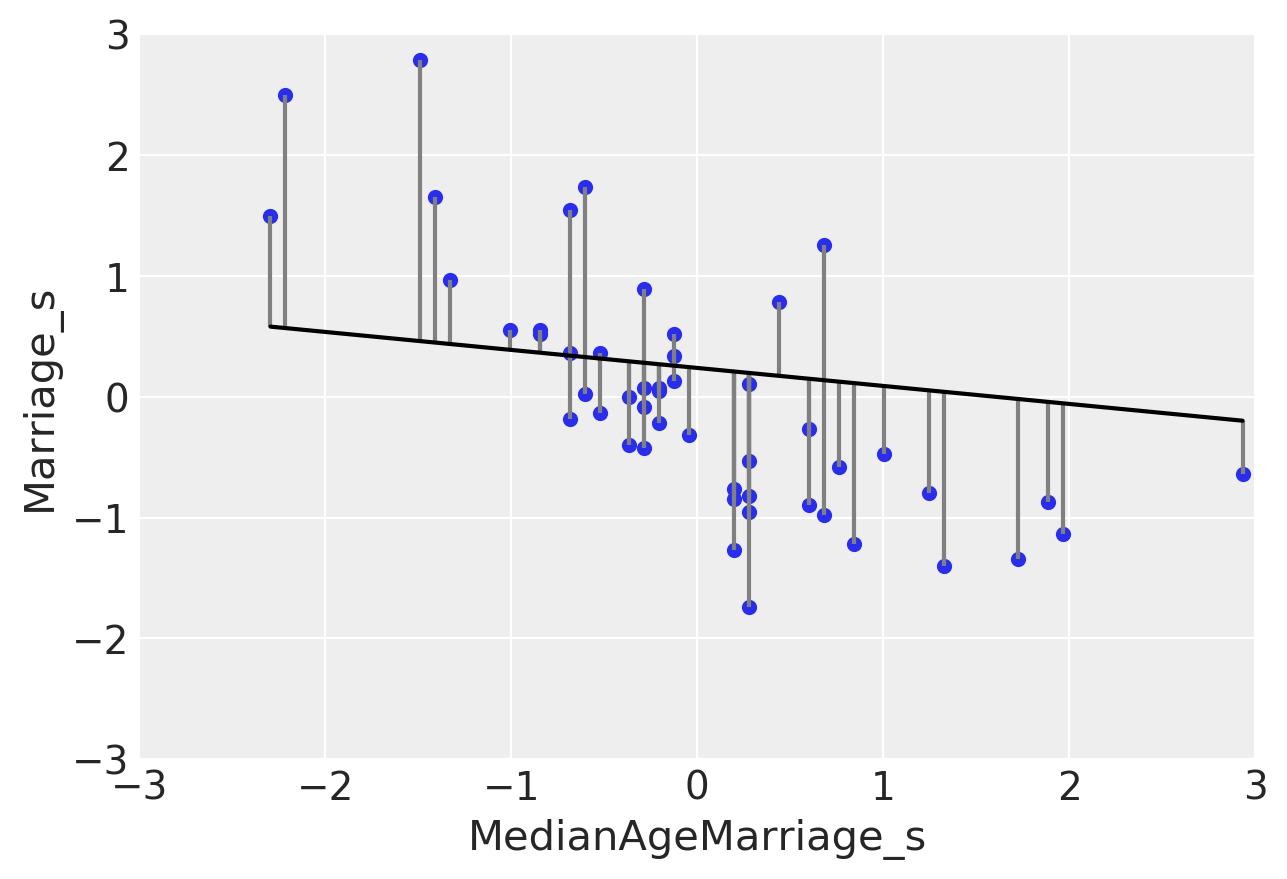

In [40]:
d.plot('MedianAgeMarriage_s', 'Marriage_s', kind='scatter', xlim = (-3, 3), ylim = (-3, 3))
plt.plot(d.MedianAgeMarriage_s[idx], predictions[idx], 'k')
plt.vlines(d.MedianAgeMarriage_s, predictions, predictions + residuals, colors='grey');